# CMS Anomaly Detection

## Prepearing data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import collections
import re

DATA_PATH = 'merged.pickle'
LABELS_PATH = './quality_2010/labels_v2.pickled'

In [2]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

with open(LABELS_PATH, 'r') as f:
    sub_labels = pickle.load(f)

labels = sub_labels['json_0.txt']

In [3]:
### technical columns
not_features = [
    '_luminosityBlock',
    '_run'
]

### columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [4]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), data['_instantLumi_muons'].get_values()),
    data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]

data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]

for k in sub_labels:
    sub_labels[k] = sub_labels[k][nonempty]

In [5]:
subsytem_descriptions = dict(
    [
        ('json_0.txt', 'inclusive global label')
    ] + [
        ('json_%d.txt' % i, desc)
        for i, desc in zip(range(15, 23), [
            '15:DQM: Rpc GOOD,\nDCS: Rpc',
            '16:DQM: Csc GOOD,\nDCS: Csc',
            '17:DQM: Dt GOOD,\nDCS: Dt',
            '18:DQM: Hcal GOOD,\nDCS: Hcal',
            '19:DQM: Ecal GOOD,\nDCS: Ecal',
            '20:DQM: Es GOOD,\nDCS: Es',
            '21:DQM: Strip GOOD,\nDCS: Strip',
            '22:DQM: Pix GOOD,\nDCS: Pix'
        ])
    ] + [
        ('json_%d.txt' % i, desc)
        for i, desc in zip(range(11, 15) + range(23, 25), [
            '11: DQM: Muon GOOD,\nDCS: Strip, Pix, Dt, Rpc, Csc on',
            '12: DQM: Jmet GOOD,\nDCS: Ecal, Hcal on',
            '13: DQM: Egam GOOD,\nDCS: Strip, Pix, Ecal on',
            '14: DQM: Track GOOD,\nDCS: Strip, Pix on',
            '23: DQM: Hlt GOOD,\nDCS: Strip, Pix, Ecal on',
            '24: DQM: L1t GOOD,\nDCS: none'
        ])
    ]
)

In [6]:
Muon = sub_labels['json_11.txt']
Ecal = sub_labels['json_19.txt']
Track = sub_labels['json_14.txt']
Strip = sub_labels['json_21.txt']
Hlt = sub_labels['json_23.txt']
Pix = sub_labels['json_22.txt']
Rpc = sub_labels['json_15.txt']
L1t = sub_labels['json_24.txt']
Csc = sub_labels['json_16.txt']
Hcal = sub_labels['json_18.txt']
Dt = sub_labels['json_17.txt']
Jetmet = sub_labels['json_12.txt']
Egamma = sub_labels['json_13.txt']
Es = sub_labels['json_20.txt']

Let's check how these assumptions about data annotation are right:

1) Track = Pix && Strip


2) Jetmet = L1tcalo && Ecal && Hcal


3) Egamma = L1tcalo && Ecal && Es && Track


4) Muon = L1tmu && Dt && Rpc && Csc&& Track


5) AllGood = Muon && Egamma && Jetmet && Track

In [7]:
syss = [Muon, Ecal, Track, Strip,Hlt, Pix, Rpc, L1t, Csc, Hcal, Dt, Jetmet, Egamma, Es]
syss_names = ['Muon', 'Ecal', 'Track', 'Strip' ,'Hlt' , 'Pix', 'Rpc', 'L1t', 'Csc', 'Hcal', 'Dt', 'Jetmet', 'Egamma', 'Es']

In [8]:
#functions to estimate the correlation between two sets of labels
def get_cor_norm4(left, right): 
    #left input will be on x axis!
    Cor = np.ones((2,2))
    th = 0.5
    Cor[0,0] = np.mean(np.where((left <= th)&(right <= th), 1, 0))
    Cor[1,1] = np.mean(np.where((left > th)&(right > th), 1, 0))
    
    Cor[0,1] = np.mean(np.where((left > th)&(right <= th), 1, 0))
    Cor[1,0] = np.mean(np.where((left <= th)&(right> th), 1, 0))
    #print Cor
    return Cor

def get_cor_norm_row(left, right):
    #left input will be on x axis!
    zeros_l = left <= 0.5
    ones_l = left > 0.5

    Cor = np.ones((2,2))

    Cor[0,0] = np.mean(np.where(right[zeros_l] <= 0.5, 1, 0))
    Cor[1,1] = np.mean(np.where(right[ones_l] > 0.5, 1, 0))
    
    Cor[1,0] = 1. - Cor[0,0]
    Cor[0,1] = 1. - Cor[1,1]
    #print Cor
    return Cor

get_cor = get_cor_norm4

## Example

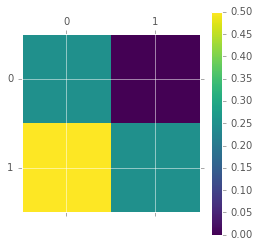

In [9]:
plt.figure(figsize=(10, 10))
plt.matshow(get_cor(np.array([0., 0., 1., 0.]), 
                    np.array([0., 1., 1., 1.])), 
            cmap=plt.cm.viridis)
plt.xticks(np.arange(2))
plt.yticks(np.arange(2))
plt.colorbar()
plt.show()

### Track = Pix && Strip

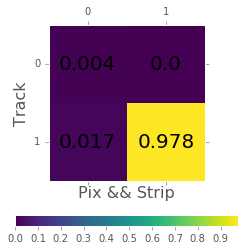

In [10]:
M = get_cor(Strip*Pix, Track)

plt.figure(figsize=(10, 10))
plt.matshow(M,cmap=plt.cm.viridis)
plt.grid(False)
plt.ylabel('Track', fontsize =16)
plt.xlabel('Pix && Strip', fontsize =16)
for yind in range(2):
    for xind in range(2):
        plt.text(xind, yind, np.round(M[yind][xind],3), va='center', ha='center', fontsize = 20)
plt.colorbar(orientation = 'horizontal')
plt.show()

Let's look at the components

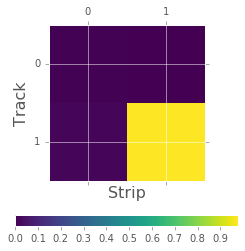

array([[ 0.00415356,  0.        ],
       [ 0.01705475,  0.97879169]])

In [11]:
plt.matshow(get_cor(Strip, Track), cmap=plt.cm.viridis)
plt.ylabel('Track', fontsize =16)
plt.xlabel('Strip', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Strip, Track)

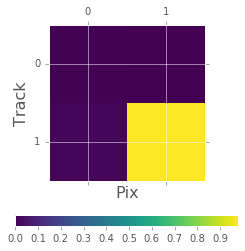

array([[ 0.00415356,  0.        ],
       [ 0.01548143,  0.98036501]])

In [12]:
plt.matshow(get_cor(Pix, Track), cmap=plt.cm.viridis)
plt.ylabel('Track', fontsize =16)
plt.xlabel('Pix', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Pix, Track)

Strip can be zero and reports 'bad' sample, when Track label is one, as for good event. The same is true for Pix. So Track does not equal to Pix & Strip.

### Jetmet = L1tcalo && Ecal && Hcal

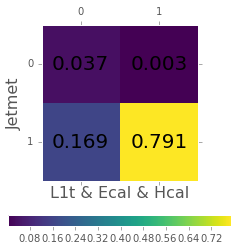

In [13]:
M = get_cor(L1t * Ecal * Hcal, Jetmet)

plt.figure(figsize=(10, 10))
plt.matshow(M,cmap=plt.cm.viridis)
plt.grid(False)
plt.ylabel('Jetmet', fontsize =16)
plt.xlabel('L1t & Ecal & Hcal', fontsize =16)
for yind in range(2):
    for xind in range(2):
        plt.text(xind, yind, np.round(M[yind][xind],3), va='center', ha='center', fontsize = 20)
plt.colorbar(orientation = 'horizontal')
plt.show()

Let's look at the components

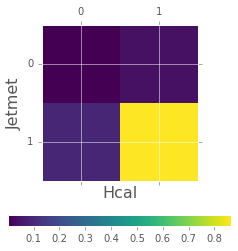

array([[ 0.00125865,  0.03908118],
       [ 0.09465072,  0.86500944]])

In [14]:
plt.matshow(get_cor(Hcal, Jetmet), cmap=plt.cm.viridis)
plt.ylabel('Jetmet', fontsize =16)
plt.xlabel('Hcal', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Hcal, Jetmet)

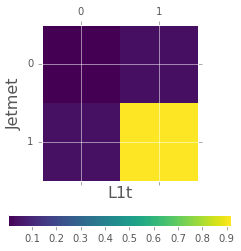

array([[ 0.00125865,  0.03908118],
       [ 0.09465072,  0.86500944]])

In [15]:
plt.matshow(get_cor(L1t, Jetmet), cmap=plt.cm.viridis)
plt.ylabel('Jetmet', fontsize =16)
plt.xlabel('L1t', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Hcal, Jetmet)

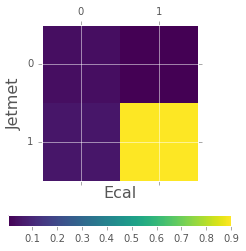

array([[ 0.00125865,  0.03908118],
       [ 0.09465072,  0.86500944]])

In [16]:
plt.matshow(get_cor(Ecal, Jetmet), cmap=plt.cm.viridis)
plt.ylabel('Jetmet', fontsize =16)
plt.xlabel('Ecal', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Hcal, Jetmet)

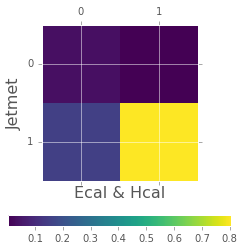

array([[ 0.00125865,  0.03908118],
       [ 0.09465072,  0.86500944]])

In [17]:
plt.matshow(get_cor(Ecal*Hcal, Jetmet), cmap=plt.cm.viridis)
plt.ylabel('Jetmet', fontsize =16)
plt.xlabel('Ecal & Hcal', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Hcal, Jetmet)

There is no expected correlations too.

### Egamma = L1t && Ecal && Es && Track

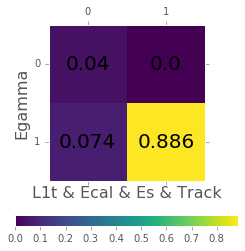

In [18]:
plt.figure(figsize=(10, 10))
M = get_cor(L1t * Ecal * Es * Track, Egamma)
plt.matshow(M,cmap=plt.cm.viridis)
plt.grid(False)
plt.ylabel('Egamma', fontsize =16)
plt.xlabel('L1t & Ecal & Es & Track', fontsize =16)
for yind in range(2):
    for xind in range(2):
        plt.text(xind, yind, np.round(M[yind][xind],3), va='center', ha='center', fontsize = 20)
plt.colorbar(orientation = 'horizontal')
plt.show()

Again there are good Egamma labels, L1t && Ecal && Es && Track equals zero.

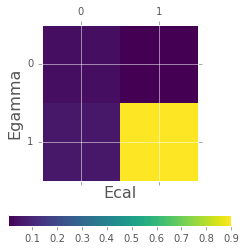

array([[ 0.00125865,  0.09509125],
       [ 0.0028949 ,  0.90075519]])

In [19]:
plt.figure(figsize=(10, 10))
plt.matshow(get_cor(Ecal, Egamma), cmap=plt.cm.viridis)
plt.ylabel('Egamma', fontsize =16)
plt.xlabel('Ecal', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Track, Ecal)

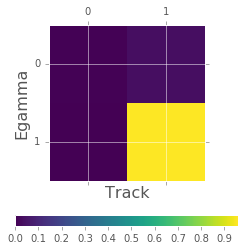

array([[ 0.00415356,  0.03580868],
       [ 0.        ,  0.96003776]])

In [20]:
plt.figure(figsize=(10, 10))
plt.matshow(get_cor(Track, Egamma), cmap=plt.cm.viridis)
plt.ylabel('Egamma', fontsize =16)
plt.xlabel('Track', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()

get_cor(Track, Egamma)

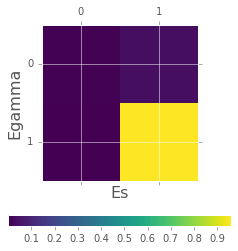

[[  3.90182505e-03   3.60604154e-02]
 [  1.25865324e-04   9.59911894e-01]]


In [21]:
plt.figure(figsize=(10, 10))
plt.matshow(get_cor(Es,  Egamma), cmap=plt.cm.viridis)
plt.ylabel('Egamma', fontsize =16)
plt.xlabel('Es', fontsize =16)
plt.colorbar(orientation = 'horizontal')
plt.show()
print get_cor(Es,  Egamma)

### Muon = L1tmu && Dt && Rpc && Csc&& Track

The equality does not hold.

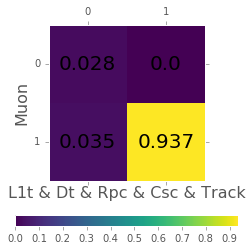

In [22]:
plt.figure(figsize=(10, 10))
M = get_cor(L1t * Dt * Rpc * Csc * Track, Muon)
plt.matshow(M,cmap=plt.cm.viridis)
plt.grid(False)
plt.ylabel('Muon', fontsize =16)
plt.xlabel('L1t & Dt & Rpc & Csc & Track', fontsize =16)
for yind in range(2):
    for xind in range(2):
        plt.text(xind, yind, np.round(M[yind][xind],3), va='center', ha='center', fontsize = 20)
plt.colorbar(orientation = 'horizontal')
plt.show()

### AllGood = Muon && Egamma && Jetmet && Track

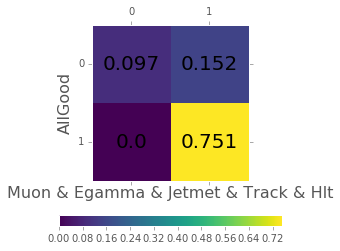

In [23]:
plt.figure(figsize=(10, 10))
M = get_cor(Muon * Egamma * Jetmet * Track * Hlt, labels)
plt.matshow(M,cmap=plt.cm.viridis)
plt.grid(False)
plt.ylabel('AllGood', fontsize =16)
plt.xlabel('Muon & Egamma & Jetmet & Track & Hlt', fontsize =16)
for yind in range(2):
    for xind in range(2):
        plt.text(xind, yind, np.round(M[yind][xind],3), va='center', ha='center', fontsize = 20)
plt.colorbar(orientation = 'horizontal')
plt.show()

### Number of anomalies in subsystems.

In [24]:
sub_systems = sorted(sub_labels.keys())
zeros_in_data = []
names_subsys = []
for sub_system in sub_systems:
    names_subsys.append(sub_system)
    zeros_in_data.append(len(sub_labels[sub_system])-np.sum(sub_labels[sub_system]))
    print (subsytem_descriptions[sub_system] +
            ':    ' + str(len(sub_labels[sub_system])-np.sum(sub_labels[sub_system]))
           )

inclusive global label:    3955.0
11: DQM: Muon GOOD,
DCS: Strip, Pix, Dt, Rpc, Csc on:    447.0
12: DQM: Jmet GOOD,
DCS: Ecal, Hcal on:    641.0
13: DQM: Egam GOOD,
DCS: Strip, Pix, Ecal on:    635.0
14: DQM: Track GOOD,
DCS: Strip, Pix on:    66.0
15:DQM: Rpc GOOD,
DCS: Rpc:    189.0
16:DQM: Csc GOOD,
DCS: Csc:    158.0
17:DQM: Dt GOOD,
DCS: Dt:    249.0
18:DQM: Hcal GOOD,
DCS: Hcal:    1524.0
19:DQM: Ecal GOOD,
DCS: Ecal:    1531.0
20:DQM: Es GOOD,
DCS: Es:    64.0
21:DQM: Strip GOOD,
DCS: Strip:    337.0
22:DQM: Pix GOOD,
DCS: Pix:    312.0
23: DQM: Hlt GOOD,
DCS: Strip, Pix, Ecal on:    585.0
24: DQM: L1t GOOD,
DCS: none:    673.0


### Anomalies distribution.

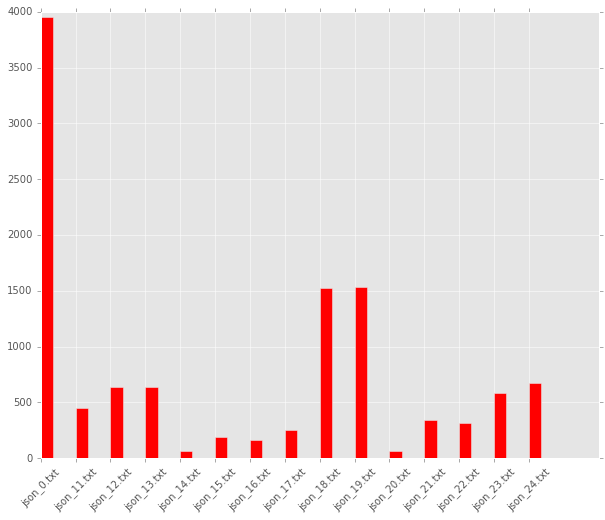

In [25]:
N = len(zeros_in_data)
ind = np.arange(N)  # the x locations
width = 0.35       # the width of the bars

plt.figure(figsize=(10, 8))
plt.bar(ind, zeros_in_data, width, color='r')
plt.xticks(ind, names_subsys, rotation=45)
plt.show()

Most of the anomalies are concentrated in Ecal and Hcal systems.

Let's focus on low-level systems (json 15 - json 22) and calculate the number of anomalies in the subsystems, which occurred in exactly one subsystem. It means, that we are searching for events, which origin is better interpretable, as anomaly is caused by one low-level system.

In [26]:
zp = [] #array with indices for all zeros in data
for sub_system in sub_systems[5:-2]: 
    zp = np.hstack((zp,np.where(sub_labels[sub_system] == 0.)[0]))
#indices for events with anomaly in exactly one subsystem
anomaly_once = [int(item) for item, count in collections.Counter(zp).items() if count == 1] 

In [27]:
zeros_once = [] #Number of unique anomalies in jsons15-22
names_subsys = []
for sub_system in sub_systems[5:-2]:
    names_subsys.append(sub_system)
    zeros_once.append(len(sub_labels[sub_system][anomaly_once])-np.sum(sub_labels[sub_system][anomaly_once]))

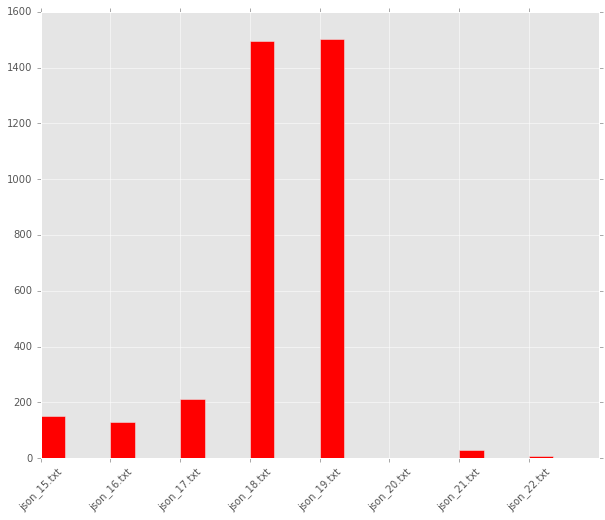

In [28]:
N = len(zeros_once)
ind = np.arange(N)  
width = 0.35      

plt.figure(figsize=(10, 8))
plt.bar(ind, zeros_once, width, color='r')

plt.xticks(ind, names_subsys, rotation=45)
plt.show()

Hcal and Ecal bars are almost the same as before. Ecal and Ecal bars are almost the same as before. It means that when there is an anomaly in this systems there is no usually any other marks about anomalies in other subsystems.

In [29]:
len(np.where((sub_labels["json_18.txt"] == 0.)&(sub_labels["json_19.txt"] == 0.))[0])

20

There are only 20 overlapping anomalies in Ecal and Hcal.

And no unique anomilies in json_20 (Es). And no unique anomalies in json_20 (Is). The next plot shows that they are overlapping either with anomalies from Strip and Pix or when anomaly detected in all systems.

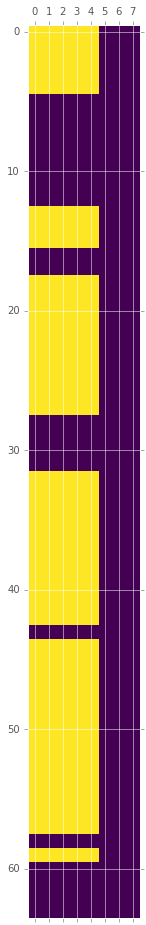

In [30]:
anomalies_m = [int(item) for item, count in collections.Counter(zp).items() 
               if count != 1 if sub_labels['json_20.txt'][int(item)]==0]
M = []
for sub_system in sub_systems[5:-2]:
    M.append(sub_labels[sub_system][anomalies_m])
plt.figure(figsize=(1, 4))
plt.matshow(np.array(M).T, cmap=plt.cm.viridis)
plt.show()